# Assignment 3

**Assignment 3: Evolutionary Algorithms**

**Goal**: Get familiar with evolutionary algorithms by implementing it and applying it to a given non-differentiable optimization task.

In this assignment, we are going to learn about evolutionary algorithms (EAs). The goal is to implement components of an evolutionary algorithm: a recombination operator, a mutation operator, and selection mechanisms, and analyze their behavior. This assignment is open to any choice of the aforementioned components​ as long as they are well motivated.

We are interested in optimizing a given **black-box** function that could be queried (i.e., it returns a value of the objective for given input values), but the gradient wrt the input cannot be calculated. The input to the system is a vector:
$$\mathbf{x} =[\alpha_0, n, \beta, \alpha]^{\top} \in [−2,10] \times [0,10] \times [−5,20] \times [500,2500]. $$

The optimized function is based on the gene repressilator model. For details, please see Section 4.2 in <a href='https://arxiv.org/abs/2002.02869' target='_blank'>HERE</a>.

## 1. Understanding the problem

The considered problem is about finding parameter values of a model widely used in biology, namely, the gene repressilator model. This model represents a simple network in which a gene (mRNA) is produced by a protein, and then this gene is used to produce another protein. Altogether, there are 3 genes and 3 proteins that are connected as follows: $m_1 \rightarrow p_1$, $p_1 \rightarrow m_2$, $m_2 \rightarrow p_2$, $p_2 \rightarrow m_3$, $m_3 \rightarrow p_3$, $p_3 \rightarrow m_1$.

Please run the code below and spend a while on analyzing the signals in the model. Think of the osscilatory character of the signals.

If any code line is unclear to you, please read on that in numpy or matplotlib docs.

In [1]:
import pickle
import copy
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

EPS = 1.e-7

%load_ext jupyternotify

<IPython.core.display.Javascript object>

In [2]:
# PLEASE DO NOT REMOVE!
# This is the main class for the gene repressilator model.
# There is no need to understand how it works! You can treat it as a black-box.
# It is important to realize that we can always ask this object to give us 
# an evaluation of given parameter values.
class Repressilator(object):
  def __init__(self, y_real, params):
    super().__init__()
    self.y_real = y_real.copy()
    self.params = params.copy()

  # The definition of the gene repressilator model as a system of ODEs.
  def repressilator_model(self, t, y):
    m1, m2, m3, p1, p2, p3 = y[0], y[1], y[2], y[3], y[4], y[5]

    alpha0 = self.params['alpha0']
    n = self.params['n']
    beta = self.params['beta']
    alpha = self.params['alpha']

    dm1_dt = -m1 + alpha / (1. + p3**n) + alpha0
    dp1_dt = -beta * (p1 - m1)
    dm2_dt = -m2 + alpha / (1. + p1**n) + alpha0
    dp2_dt = -beta * (p2 - m2)
    dm3_dt = -m3 + alpha / (1. + p2**n) + alpha0
    dp3_dt = -beta * (p3 - m3)

    return dm1_dt, dm2_dt, dm3_dt, dp1_dt, dp2_dt, dp3_dt

  # A numerial solver for the model (here we use Runge-Kutta 4.5)
  def solve_repressilator(self):
    # we need to use lambda function if we want to pass some parameters
    solution = solve_ivp(lambda t, y: self.repressilator_model(t, y), 
                         t_span=(self.params['t0'], self.params['t1']),
                         y0=self.params['y0'],
                         method='RK45', t_eval=self.params['t_points'])
    y_points = np.asarray(solution.y)
    return self.params['t_points'], y_points

  # An auxiliary function: setting parameters.
  def set_params(self, x):
    self.params['alpha0'] = x[0]
    self.params['n'] = x[1]
    self.params['beta'] = x[2]
    self.params['alpha'] = x[3]

  # Calculating the objective function.
  # Here, we use the Euclidean distance between the real data and the synthetic data.
  @staticmethod
  def loss(y_real, y_model):
    # we assume only m's are observed!
    y_r = y_real[0:3]
    y_m = y_model[0:3]
    if y_r.shape[1] == y_m.shape[1]:
      return np.mean(np.sqrt(np.sum((y_r - y_m)**2, 0)))
    else:
      return np.infty

  def objective(self, x):
    if len(x.shape) > 1:
      objective_values = []
      for i in range(x.shape[0]):
        xi = x[i]
        self.set_params(xi)

        _, y_model = self.solve_repressilator()
        objective_values.append(self.loss(self.y_real, y_model))

      objective_values = np.asarray(objective_values)
    else:
      self.set_params(x)

      _, y_model = self.solve_repressilator()
      objective_values = self.loss(self.y_real, y_model)

    return objective_values

In [3]:
# PLEASE DO NOT REMOVE!
# Initialize the problem.
# Here we set the real parameters and generate "real" data. To make the problem 
# more realistic, we add a small Gaussian noise.
params = {}
params['alpha0'] = 1.1
params['n'] = 2.9
params['beta'] = 5.5
params['alpha'] = 500
params['t0'] = 0.
params['t1'] = 60.5
params['t_points'] = np.linspace(0,60,120,endpoint=False)
params['x0'] = np.asarray([[5.64167522, 2.07180539, 3.56690274, 7.0015145 ]])
params['y0'] = np.asarray([0.0, 0.0, 0.0, 2.0, 1.0, 3.0])

# Generate "real" data
r = Repressilator([0], params)
_, y_real = r.solve_repressilator()
del(r) # we remove the object, just in case
y_real = y_real + np.random.randn(*y_real.shape) * 5. # add noise!

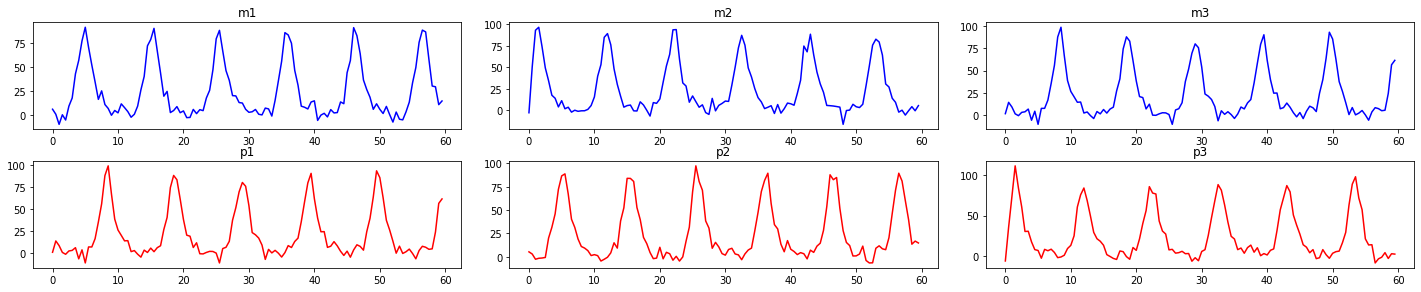

In [4]:
# PLEASE DO NOT REMOVE
# Here, we plot all signals in the model.
# Note that later on, we assume that only gene expression (i.e., m1, m2, m3)
# are observed (blue plots) and proteins (i.e. p1, p2, p3) are unobserved (in red).
t = params['t_points']

fig_data, axs = plt.subplots(2,3,figsize=(20, 4))
fig_data.tight_layout()

for i in range(2):
  for j in range(3):
    if i == 0:
      title = 'm'
      color = 'b'
    else:
      title = 'p'
      color = 'r'
    
    axs[i,j].plot(t, y_real[2*i+j], color)
    axs[i,j].set_title(title + str(j+1))

## 2. Evolutionary Algorithms

In this assignment, you are asked to implement an evolutionary algorithm (EA). Please take a look at the class below and fill in the missing parts. Please keep in mind that you are free to choose any operations as lons as they are appropriate for evolutionary algorithms.

NOTE: Please pay attention to the inputs and outputs of each function.

**Question 1 (0-0.5pt):** Do you use a mutation operator? If yes, please explain in detail your choice. If not, please explain why not.

**Answer:** 

In my implementation, I use a mutation operator. The function takes all children (offspring) that have been created this iteration as input and randomly selects a few of them. The number of children selected is based on the hyperparameter 
$\textit{mutation_prob}$, this number is taken as a mean for a draw from a gaussian distribution. The standard deviation was found to work well at a value of 5 since that generates broader draws, which makes the number of mutated children per generation fluctuate more. Having a fixed number of mutated offspring would have been less representative of natural processes I think. 

Once the children are randomly selected (given the number that was drawn from the normal distribution), every child is individually considered. For each child, three different mutation operations are possible that are randomly picked with equal likelihood. One of the operations rounds the floating point gene values of the genotype to integer values. This mutation might be good when most of the generation is closely positioned around one point. Then, a child that is mutated with this operation is adjusted slightly in position which might make it find an even more optimal point. Another mutation that was implemented is the random swapping of gene values in the genotype of children. Two (with equal likelihood) chosen genes are selected and their values swapped. This is a process that might happen in nature where during creation of the new offspring, something goes wrong in the gene passing, leading to missplaced genes. For the algorithm, it might be useful in order to escape local minima. The third functionality in place is that the value of one randomly chosen gene is updated. The update happens based on a normal distribution $X \sim \mathcal{N}(\mu=gene\_val,\sigma^2=log_2(x+1))$. The $log_2$ formula is used in order to ensure that with increasing genetic values, $x$s are chosen that lie further away from the mean.

Once all children's genotype that were chosen for mutation are updated, the chilren's genes are passed on to the selection step where they might or might not be selected to move to the next generation.

**Question 2 (0-0.5pt):** Do you use a cross-over operator? If yes, please explain in detail your choice. If not, please explain why not.

**Answer:** 

Similarly to the mutation operation function, I also use different randomly chosen methods for the cross-over operation. Generally, the operations are in place in order to create offspring from parents while ensuring that the offspring's genotype is slightly adjusted in order to enable the possibility for finding more optimal points in the search space. The way that parents are matched up to create offspring is random. They are completely randomly chosen from the current population since "bad" parents have already been weeded out in the previous step to this function ("parent selection"). With this implementation I therfore assume that each parent is able to generate infinite offspring in each generation. The two recombination operations that are in place are randomly chosen when two parents "meet". One of them is a simple cross-over method where for each gene value, one parents is chosen at random that inherits their value to the child's genotype. In other words, the genes are randomly recombined but their order is respected and kept stable during this operation. The second operation is a more 'interesting' (and perhaps more effective) approach which takes the average of both parents (so the center point of the shortest line of their two genotype vectors) and then draws the offspring's genotype from a gaussian distribution which is centered around that middle point. The standard deviation was set to the parent's distance over $4$ since that ensures that out of $100$ draws, approximately $97\%$ of the samples lie between the parents and not outside. But this might still happen in some cases. Each sample in this method is thus drawn from: $X \sim \mathcal{N}(\mu=center\_point,\sigma^2=\frac{parental\_distance}{4})$.

**Question 3 (0-0.5pt):** What kind of selection mechanism do you use? Please explain in detail and motivation your choice.

**Answer:** 

The parent selection function is a very important step in the evolutionary algorithm since it determines which genotypes are passed on to the next generation and which not. Parents are selected based on their performance, since that is indicative of their low (better) fitness in the environment. The parents are first separated in two groups, one of which stores those parents that perform infinitely bad. While their performance in this generation might be bad, they could hold important values and their offspring could technically still find good minima. This is why a certain number of the "==inf parents" are selected. The number of selected ==inf parents is determined based on how many are maximally allowed to be selected (hyperparameter $percentage\_inf\_parents$) and how many there actually are in the current generation. This is done with a $min(  )$ function that takes both of those numbers in. If the number of ==inf parents is larger than the number of them allowed into the next generation, then the $min()$ function will select the maximally allowed number of those parents. In other cases, where there might be very few or even no infinite parents at all in the generation, the $min()$ function will select that minimal number over the margin of maximally allowed. 

All parents that are not infinitely bad in their fitness ("!=inf parents") form the other group. From this group, there are $n$ samples drawn where $n=\text{population_total}-\text{count}(==\text{allowed_inf_parents})$. The sampling happens with replacement (since I am modelling that parents might have multiple children within one generation) and based on weights. These weights are not according to fitness values but rather by ranking. All !=inf parents are ranked adcendingly by their fitness and weights are assigned based on their individual positioning in the ranking. This is not just linear (meaning that $1$st has $99\%$, $50$th then $50\%$ chance etc.) but rather according to a third degree polinomial whose hyperparameter function values are specifically tailored to this task:

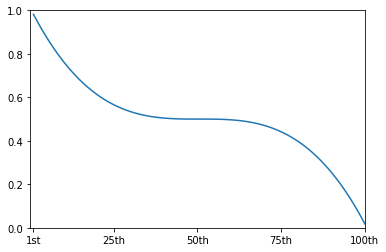

In [5]:
space = np.linspace(0.01,1,100,endpoint=False)
third_deg_polynomial = 1-(1.6*space-0.8)**3-0.5
plt.plot(space,third_deg_polynomial)
plt.xticks((0.01,0.2476,0.4951,0.7426,0.9901), ("1st", '25th',"50th",'75th', "100th"))
plt.ylim([0,1])
plt.xlim([0,0.9901]);

As one can observe, the lower the $x$-axis value, the higher the likelihood of being sampled. I inititally thought that just taking a linear function would be okay but then considered that it might be much more useful to sample the parents further away from the optimum (around $x=0.5$) almost uniformly since their values do not make much of a difference. This polinomial therefore prioritizes the values that are more optimal (low $x$'s), then makes the weights almost uniform for mediocre parents and gives bad parents slightly more chance to be sampled. 

I also tried the following polynomial function, but it yielded worse resuls than the one described above:

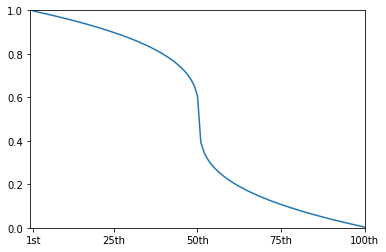

In [6]:
third_deg_polynomial = -0.63*np.power(np.abs(space-0.5),1./3)*np.sign(space-0.5)+0.5
plt.plot(space,third_deg_polynomial)
plt.xticks((0.01,0.2476,0.4951,0.7426,0.9901), ("1st", '25th',"50th",'75th', "100th"))
plt.ylim([0,1])
plt.xlim([0,0.9901]);

**Question 4 (0-0.5pt):** Do you use any other operation? If yes, please explain and motivate your choice.

**Answer:** 

The tournament implementation that matches two individuals and lets the better one advance to the next generation is an efficient and quick way to keep good and throw away bad results. I initially thought that this is close to random selection but after thinking about it for some time, I have to say that it does work quite well. Not only does it eliminate the worst and with a probability of 100% keep the best, it also doesn't stoicly eliminate potentially bad individuals. This is also quite essential in an evolutionary algorithm since those "bad" genotypes might yield exceptional children that fall into a global optimum only when their genotype is formed from a well-performing and a bad-performing parent in the next generation.

**Question 5 (0-0.5-1pt):** Please provide a pseudo-code for your evolutionary algorithm. Please try to be as formal as possible!

**Answer:**

In [15]:
import scipy
from sklearn.preprocessing import normalize
import random
from random import choices, sample, choice
import math
from numpy.random import uniform as uniform
# =========
# GRADING:
# 0 
# 0.5 pt if code works but some functions are incorrect and it is badly explained
# 1.0 pt if code works but some functions are incorrect
# 2.0 pt if code works but it does not correspond to the description above and it is badly explained
# 2.5 pt if code works and it is well explained, but it does not correspond to the description above
# 3.0 pt if code works and it is aligned with the description about, but it is badly explained
# 3.5 pt if code works and it is aligned with the description about, and it is well explained
# 4.0 pt if code works, it is as it was described, it is well explained, and the proposed operations are beyond the lecture!
#=========
# Implement the Evolutionary Algorithm (EA) algorithm. 
# It is equivalent to implementing the step function.
class EA(object):
    def __init__(self, repressilator, pop_size,
                 mutation_prob=0.1,
                 percentage_inf_parents=0.1):
        self.repressilator = repressilator
        self.pop_size = pop_size
        self.percentage_inf_parents = percentage_inf_parents
        self.mutation_prob = mutation_prob
   

    def third_poly(self,np_arr): 
        """
        this hand-crafted third degree polinomial adds particular weight to the
        candidates. it is used to adjust the weights (acceptance rates) that are 
        element of range (0,1).
        """
        return 1-(1.6*np_arr-0.8)**3-0.5

    
    def parent_selection(self, x_old, f_old): 
        """
        parents are selected based on their performance. they are first ranked and 
        then assigned weights. the weights are adjusted according to the third_poly() 
        function. parents with infinitely bad performance are looked at separately, 
        they are kept as parents using min( maximal percentage of inf parents, nr of 
        total inf parents ) since there might be less parents with infinitely bad 
        performance than maximally accepted
        """
        okay_performing_parents = []
        inf_bad_performing_parents = []
        for i in range(len(x_old)): # loop categorizing parents in ==inf & !=inf perf.
            parent = x_old[i]
            performance = f_old[i]
            if performance == np.inf:
                # datastructure where performance and genes are adjacent
                # this was more handy for sorting the lists
                inf_bad_performing_parents.append((performance,parent))
            else:
                okay_performing_parents.append((performance,parent))
        
        # sorting !=inf parents from low to high (since low is better)
        okay_performing_parents.sort(key=lambda x: x[0])
        
        # creating the acceptance rate weights by creating probabilities
        # and passing them through the third_poly() function
        parent_weight_lin_space = np.linspace(0.01,1,len(okay_performing_parents),
                                              endpoint=False)
        parent_selection_weights = self.third_poly(parent_weight_lin_space)
        
        # determining the nr of parents to select by taking 
        #min(maximally accepted nr of ==inf parents, total nr of actual ==inf parents)
        nr_inf_parents_to_select = min(round(self.pop_size*self.percentage_inf_parents),
                                       len(inf_bad_performing_parents))
        # the nr of the parents !=inf are the difference of ==inf and the total 
        # desired nr of parents
        nr_okay_parents_to_select = self.pop_size - nr_inf_parents_to_select
        
        # drawing parent samples with replacement from the set of parents !=inf
        # according to the list of weights defined earlier with help of the polynomial
        not_inf_parents_samples = choices(okay_performing_parents, 
                                          parent_selection_weights, 
                                          k=nr_okay_parents_to_select)
        inf_parents_samples = choices(inf_bad_performing_parents,
                                      k=nr_inf_parents_to_select)
        
        # reshaping data to fit the general architecture of the program
        x_parents = np.asarray([x[1] for x in not_inf_parents_samples] 
                               + [x[1] for x in inf_parents_samples])
        f_parents = np.asarray([x[0] for x in not_inf_parents_samples] 
                               + [x[0] for x in inf_parents_samples])
        
        return x_parents, f_parents # newly selected parents and their fitness values

    
    def recombination(self, x_parents, f_parents):
        """
        function that reshapes the genome of parents utilizing two different methods:
        1. new genes are combined randomly from both parents, (respecting order)
        2. new genes are sampled from the multivariate (multiple genes) normal 
           distribution that is individually fitted to all genetic means of the two
           parents. the standard deviation is chosen based on the distance of the 
           mean from both parents (half the radius of the circle spanned by the 
           shortest distance (representing the diameter))
        both methods are randomly chosen for each child with equal likelihood 
        """
        # initialize the genotype of the new children (4 genes per child)
        x_children = np.zeros((self.pop_size,4))

        for i in range(self.pop_size): # loop as often as nr of children desired
            
            # random indices for parent selection
            random_indices = sample(range(x_parents.shape[0]), 2)
            
            # selecting genotype and performance of both parents
            f = f_parents[random_indices]
            x = x_parents[random_indices, :]
            parent1_x = x[0]
            parent2_x = x[1]
            
            # initializing genes of new child
            child_x = np.zeros(shape=(4))
            
            if uniform() > 0.5: # in half the cases do
                # generate random binary vector
                gene_choice_binary = np.random.randint(2, size=4)
                for j in range(len(gene_choice_binary)): # for each gene do
                    if gene_choice_binary[j] == 1: # if 1, select from parent 1
                        child_x[j] = parent1_x[j]
                    else:                          # else select from other parent
                        child_x[j] = parent2_x[j]
            
            # in the other half of cases do
            else: 
                # calculating the averages (centers of the gaussians)
                avg_genes = (parent1_x + parent2_x) / 2
                # calculating the distance from averages to parents
                diff_genes = (parent1_x - avg_genes)
                
                for j in range(4): # for each gene do
                    # take sample from gaussian with mean=average, 
                    # sd=absolute value(parental distance from mean / 2)
                    # absolute value because module does not accept negative
                    # standard deviations
                    child_x[j] = np.random.normal(avg_genes[j],abs(diff_genes[j]))
            
            # update the child's genotype based on one of the two functions
            x_children[i] = child_x
            
        return x_children # returns all newly generated genotypes of children 
    
    
    def mutation(self, x_children):
        """
        function that randomly mutates children based on three different 
        functionalities that are randomly sampled with equal likelihood:
        1. round genotype of floats to integers
        2. swap position of two randomly chosen genes 
        3. update a random gene by sampling from gaussian with 
           mean=gene and sd=log_2(x+1)
           the log_2(x+1) function ensures that with higher gene values,
           higher sd's are selected
        """
        # draw from normal distribution how many children actually mutate
        # this is done to give a bit of variance each iteration
        nr_mutation_children = abs(round(
            np.random.normal(self.mutation_prob*self.pop_size,5)))
        
        # random indices of children that are to be mutated
        random_indices = sample(range(len(x_children)), nr_mutation_children)
        
        for i in random_indices: # for each mutation child do            
            if uniform() > 2/3: # divides the probabilities equally
                                          # over the three mutation operations
                # round all genes to integer values
                x_children[i] = np.rint(x_children[i])

            if uniform() > 1/2:
                # swap two random genes
                rand_genes = sample(range(0,4), 2)
                # swapping the values of the genotype at two random pointer positions
                x_children[i][rand_genes] = x_children[i][rand_genes[::-1]]
            else:
                # select gene randomly
                rand_gene = np.random.randint(0,4)
                # mean of gaussian on gene value
                mean = x_children[i][rand_gene]
                # std of gaussian based on log_2 function
                # this ensures that with larger gene values, samples
                # are drawn from further away
                sd = math.log(abs(x_children[i][rand_gene])+1,2)
                # draw new random value for the random gene from gaussian
                x_children[i][rand_gene] = np.random.normal(mean,sd)
        return x_children # returns the children including randomly mutated genes

    
    def survivor_selection(self, x_old, x_children, f_old, f_children):
        """
        function that selects the next generation based on the current parent and 
        children generation. this happens based on paired matching where
        two randomly drawn candidates' performances are compared and the one with
        lower (better) fitness chosen to advance to the next generation
        """
        # array storing the new generation of genotypes and their performances:
        # [ (performance_1, genotype_1), ... (performance_n, genotype_n) ]
        total_pop = []
        
        # loop over parents and children and append them to the new datastructure
        for i in range(len(x_old)):
            total_pop.append((f_old[i], x_old[i]))
        for i in range(len(x_children)):
            total_pop.append((f_children[i],x_children[i]))
        
        # list storing the lucky candidates advancing as parents of the next 
        # generation
        survivors = []

        while len(total_pop) > 1: # loops while total_pop list is not empty
                                  # > 1 chosen in order to avoid possible 
                                  # infinite loop when ==1 and unequal list size
            
            # randomly draw two competitors without replacement
            competitor1 = total_pop.pop(np.random.randint(0,len(total_pop)))
            competitor2 = total_pop.pop(np.random.randint(0,len(total_pop)))
            
            # if they have equal performance, let one of them randomly advance
            if competitor1[0] == competitor2[0]:
                survivors.append(choice([competitor1,competitor2]))
            
            # if competitor 1 has better (lower) performance, let that one advance
            if competitor1[0] < competitor2[0]:
                survivors.append(competitor1)
            
            # if competitor 2 has better (lower) performance, let that one advance
            else:
                survivors.append(competitor2)
        
        # reshaping data to fit general code architecture 
        x = np.asarray([x[1] for x in survivors])
        f = np.asarray([x[0] for x in survivors])

        return x, f


    def evaluate(self, x):
        return self.repressilator.objective(x)
  

    def step(self, x_old, f_old):
        """
        function that selects the next generation based on the current by going 
        trough several steps of parent selection, recombination, mutation, 
        evaluation and survivor selection
        """
        x_parents, f_parents = self.parent_selection(x_old, f_old)
        x_children = self.recombination(x_parents, f_parents)
        x_children = self.mutation(x_children)
        f_children = self.evaluate(x_children)
        x, f = self.survivor_selection(x_old, x_children, f_old, f_children)

        return x, f # passes the new genotypes and performances to next generation

**NOTE 1**

Since this assignment allows you implementing your own operations, this is difficult to prepare a code for that. Therefore, please use the code below to find the best set of your hyperparameters in a separate file, and then present your analysis for the best valyes of the hyperparameters here.

**NOTE 2**

Additionally, please do try various population sizes (25, 50, 100, ...). You will be asked about it later.

In [16]:
%%notify
# PLEASE DO NOT REMOVE!
pop_size = 100
bounds_min = [-2., 0., -5., 0.]
bounds_max = [10., 10., 20., 2500.]
num_generations = 50 
mutation_prob = 0.5
percentage_inf_parents = 0.05

# Initialize the repressilator
repressilator = Repressilator(y_real, params)

ea = EA(repressilator=repressilator, pop_size=pop_size)

# init the population
x = np.random.uniform(low=bounds_min, high=bounds_max, size=(pop_size, 4))
f = ea.evaluate(x)

# We want to gather populations and values of the best candidates to further
# analyze the algorithm.
populations = []
populations.append(x)
f_best = [f.min()]

# Run the EA.
for i in range(num_generations):
    x, f = ea.step(x, f)
    populations.append(x)
    if f.min() < f_best[-1]:
        f_best.append(f.min())
    else:
        f_best.append(f_best[-1])
    if i % int(num_generations * 0.1) == 0:
        print('Generation: {}, best fitness: {:.2f}'.format(i, f.min()))
print('FINISHED!')

C:\Users\CE2C3~1.GRE\AppData\Local\Temp/ipykernel_40384/2191093490.py:23: RuntimeWarning: invalid value encountered in double_scalars
  dm2_dt = -m2 + alpha / (1. + p1**n) + alpha0
C:\Users\CE2C3~1.GRE\AppData\Local\Temp/ipykernel_40384/2191093490.py:21: RuntimeWarning: invalid value encountered in double_scalars
  dm1_dt = -m1 + alpha / (1. + p3**n) + alpha0
C:\Users\CE2C3~1.GRE\AppData\Local\Temp/ipykernel_40384/2191093490.py:25: RuntimeWarning: invalid value encountered in double_scalars
  dm3_dt = -m3 + alpha / (1. + p2**n) + alpha0


Generation: 0, best fitness: 36.44


C:\Users\CE2C3~1.GRE\AppData\Local\Temp/ipykernel_40384/2191093490.py:21: RuntimeWarning: overflow encountered in double_scalars
  dm1_dt = -m1 + alpha / (1. + p3**n) + alpha0
C:\Users\CE2C3~1.GRE\AppData\Local\Temp/ipykernel_40384/2191093490.py:25: RuntimeWarning: overflow encountered in double_scalars
  dm3_dt = -m3 + alpha / (1. + p2**n) + alpha0
C:\Users\CE2C3~1.GRE\AppData\Local\Temp/ipykernel_40384/2191093490.py:23: RuntimeWarning: overflow encountered in double_scalars
  dm2_dt = -m2 + alpha / (1. + p1**n) + alpha0


Generation: 5, best fitness: 15.64
Generation: 10, best fitness: 15.64
Generation: 15, best fitness: 14.06
Generation: 20, best fitness: 11.77
Generation: 25, best fitness: 11.01
Generation: 30, best fitness: 10.64
Generation: 35, best fitness: 9.16
Generation: 40, best fitness: 8.72
Generation: 45, best fitness: 8.65
FINISHED!


<IPython.core.display.Javascript object>

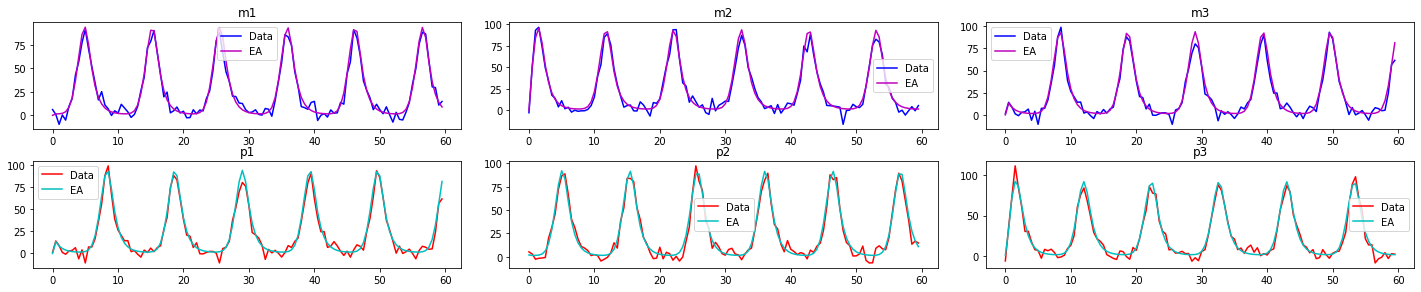

In [19]:
# PLEASE DO NOT REMOVE
# Generate signals for the best performing parameter values
repressilator.set_params(x[f.argmin()],)
t, y_best = repressilator.solve_repressilator()

# Create plots
fig_ea, axs = plt.subplots(2,3,figsize=(20, 4))
fig_ea.tight_layout()

for i in range(2):
  for j in range(3):
    if i == 0:
      title = 'm'
      color = 'b'
      color_m = 'm'
    else:
      title = 'p'
      color = 'r'
      color_m = 'c'
    
    axs[i,j].plot(t, y_real[2*i+j], color, label='Data')
    axs[i,j].plot(t, y_best[2*i+j], color_m, label='EA')
    axs[i,j].set_title(title + str(j+1))
    axs[i,j].legend()

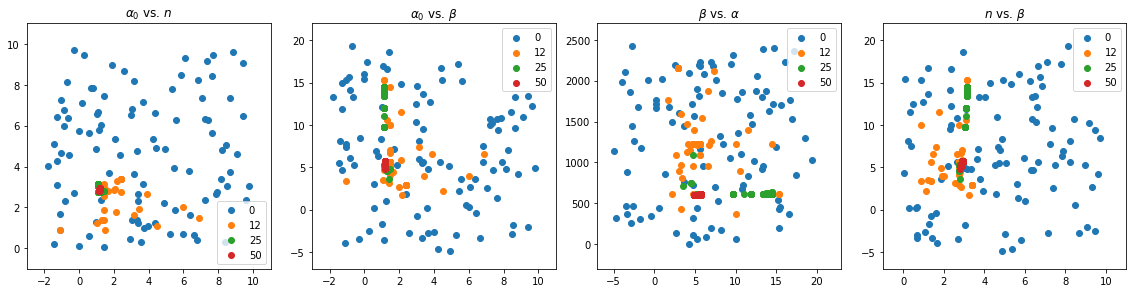

In [20]:
# PLEASE DO NOT REMOVE
# Generate scatterplots for the populations
gens = [0, num_generations//4, num_generations//2, num_generations]
fig_ea_pops, axs = plt.subplots(1,4,figsize=(16, 4))
fig_ea_pops.tight_layout()


for i in range(len(gens)):
    pop_i = populations[gens[i]]
    axs[0].scatter(pop_i[:,0], pop_i[:,1], label=str(gens[i]))
    axs[1].scatter(pop_i[:,0], pop_i[:,2], label=str(gens[i]))
    axs[2].scatter(pop_i[:,2], pop_i[:,3], label=str(gens[i]))
    axs[3].scatter(pop_i[:,1], pop_i[:,2], label=str(gens[i]))
axs[0].legend(), axs[1].legend(), axs[2].legend(), axs[3].legend()
axs[0].set_title(r'$\alpha_0$ vs. $n$')
axs[0].set_xlim([-3,11])
axs[0].set_ylim([-1,11])
axs[1].set_title(r'$\alpha_0$ vs. $\beta$')
axs[1].set_xlim([-3,11])
axs[1].set_ylim([-7,22])
axs[2].set_title(r'$\beta$ vs. $\alpha$')
axs[2].set_xlim([-7,23])
axs[2].set_ylim([-300,2700])
axs[3].set_title(r'$n$ vs. $\beta$')
axs[3].set_xlim([-1,11])
axs[3].set_ylim([-7,22]);

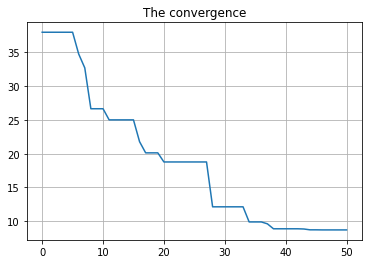

In [18]:
# PLEASE DO NOT REMOVE
# The convergence plot: the best value of the fitness function for each generation
plt.plot(range(len(f_best)), f_best)
plt.title('The convergence')
plt.grid()

## 4. Final remarks: Analysis

Eventually, please answer the following last questions that will allow you to conclude the assignment.

**Question 6 (0-0.5pt)**: After analyzing the results, do you think your algorithm discovered the real values of the parameters? Why? Please indicate which plots indicate that? If not, what is a potential explanation?

**Answer**: 

I believe that my implementation found a good (but not optimal) set of parameters that describe well the productions of the proteins over time. There are three indicators that speak for this conclusion:
1. The graphs that depict the actual vs the predicted occurence of genes and proteins: The measured shape of the curves is quite closely estimated by the predictive curves, meaning that curves of prediction and actual data are closely aligned. Hence, I can conclude that a set of parameters was found that is a good estimation of the natural, biological process. They can therefore be used to predict the occurence of genes and proteins.
2. The convergence plot shows the fitness minimization process over generations. The convergence always follows a negative exponential (minimization) or logarithmic (maximization) shape. This happens because initially, a lot of improvement can be made since random initialization is not a good fit to the objective function. Later, as the algorithm moves closer and closer to the optimum, optimization is minimal but still occuring. Loss will never be 0 because of measure error and since nature does not represent perfect curves but rather some estimation of it. Overall, the shape of my convergence curve shows exactly this shape. A lot of improvent initially, and slow convergence towards some minimal loss over time. If I was to increase the number of generations, the loss would still get slightly lower but never 0. In inifinity, it would look like a straight line which is why a limited number of generations that already represents acceptable results is enough.
3. The "real" values of the parameters were defined in the blackbox part above that is not known in the problem domain but it can be used to check the solution. This is not possible in a real-world application since the global optima are unknown but here it is feasible. The values are $\alpha_0 = 1.1$, $n=2.9$, $\beta=5.5$, and $\alpha=500$. In the scatterplots that depict the final position of the 50th generation, I can see that most of the red dots have centered around those real values. Some of them are slightly off the perfect solution but they have found an acceptable approximation given also the first two points that I describe above.

**Question 7 (0-0.5pt)**: How the population influences the performance of evolutionary algorithms? What population sizes did you use?

**Answer**: 

With increasing population size, the algorithm becomes computationally more expensive and needs extensively more time to compute. With lower population size, fewer samples are taken in the search space which means that the chance of picking a combination of genes (genotype) that closely resembles a near optimal solution is less likely. If there are more individuals in a population, then there is more variety and a higher chance of advantageous mutations. I initially increased the population size to $500$ but given the complexity of my implementation, I had to interrupt the process after 10 generations since only that took about 5 to 10 minutes to compute. I also tried lowering the population size (to $10$ and $50$) which did not yield very satisfactory results; the frequency with which the algorithm found a solution with overall fitness lower than 15 ("15-barrier") significantly decreased with those lower population sizes. This is, of course, also justified given my explanation. While I found it difficult to estimate the perfect population size given the notable variation of fitness results of my algorithm (which I think comes from the random initialization where no individual might be placed in the valley of the global optimum and no mutation randomly puts a child there) but I ended up settling on the predefined $100$. This gave me a good balance between lower run time and results that frequently broke the 15-barrier which I found to be quite close to an optimal overall fitness.

**Question 8 (0-0.5pt)**: What are the advantages of your approach?

**Answer**: 

I think there are several points that make my implementation a good approach to solving this minimization objective:
- Parent selection based on weights adjusted with polynomial: I think that sampling parents with replacement makes perfect sense when implementing an evolutionary algorithm since good parents should be prioritized and therefore enabled to have multiple children during one generation. Adjusting the weights not based on performance but rather on ranking and then having the weights not be linearly spaced (by passing them through the polynomial curve) is also good since it gives exceptionally parents a selection advantage while mediocre parents are selected almost with equal likelihood (i.e. uniformly).
- Before the survivor selection step, there exist $100$ parents and $100$ offspring which make up a population of $200$ individuals with differing genotype. In order to make a good selection which $100$ genotypes (hyperparameter $population\_size$) advance to the next generation to form the next parent generation, I implemented a $1$v$1$-tournament structure. Two genotypes are randomly drawn without replacement from the $200$ that are available. Those two individuals are compared by their fitness and the fitter one (lower = better fitness) advances to the next generation. If the two have equal fitness values, one of them is randomly chosen. This method ensures that exactly $100$ parents will produce offspring in the next generation. It also prefers good over bad fitness but still enables potentially bad parents to advance to the next generation that might have important information stored even though their fitness might be further from the (possibly local) optimum.
- While having different mutation methods could be seen as a downside (as I will explain below), it also yields the possibility of mutating offspring into several directions. This might be advantageous when compared to some kind of implementation where only one method of mutation is applied which affects children's genotype in a narrower way - thus leading to less exploration.

**Question 9 (0-0.5pt)**: What are the drawbacks of your approach?

**Answer**: 

I think that my mutation operations are not super advantageous and could be improved. With more time on hand, I would have implemented different mutation operations that would have mutated those children with better fitness with higher likelihood while keeping a copy of them and replacing worse children with the mutated version. This way, the algorithm is exploiting more since children are sampled in close relationship with the optima.

Having several operations included in the mutation of genes and in the recombination when combining parental genotypes to form the offspring makes it rather difficult to debug code since there is no clear indication as to which method contributed to which effect. Not only is debugging less simple, having this approach also makes the optimization of the algorithm more complicated since performance cannot be analyzed on isolated variables. I did, however, play around with the probabilities to isolate the methods and that way understand their impact on the performance - but this would not be necessary if just one method was set in place. I think that in a real-world environment, there should rather be one method since it is faster to optimize. I chose this approach of multiple methods since this assignment asks to show a deep understanding of the algorithm. This, I can show more easily by showing a variety of methods that all work in their own way and are randomly selected in a step.

I think overall, I did a sufficient job of showing that I have a good understanding of this evolutionary algorithm technique. However, I also know that my solution would be much cleaner with more time on hand. I think that designing this algorithm with an example that is more closely applicable to my daily environment would have yielded an even higher motivation to optimize since I would be able to measure the effect that I have instead of comparing predictive loss of a highly complex biological method.

Another drawback I can see is that my generation of offspring is rather linear, which can be seen in the location plots that show the location of the parameters as they converge to an optimum over time. Since the search space is not linear but highly dimensional, I think that combining the two genotypes of parents in a different way might yield higher performance since their offspring does not simply lie in their center but rather somewhere in their shared proximity.

**Question 10 (0-0.5pt)**: How could you improve convergence speed of your algorithm? Please provide very specific answer, ideally supported with literature and mathematical formulas.

**Answer**: 

I find it more interesting to think about solutions that I can come up with myself rather than then looking at preexisting solutions from the literature and finding those solutions in some paper:
- When generating offspring, matching "attractive" parents more often (those with lower (better) fitness) are more attractive mates and thus can pass their genotype to the next generation more often
- When generating offspring, matching parents that are closer together in a region and that way explore multiple possibly local minima at once instead of going the rather messy approach of just taking two parents that were selected based on weights
- Calculating the gradient of each parent and generating children in the direction of the negative gradient (pointing downhill) which makes the children be positioned closer to the (local) optima
- Using selection temperature that initially, samples from the generation more uniformly and then, over time, samples better parents with a higher tendency. This approach would need an increase in the number of computed generations though since convergence speed would be lower. On the other hand, it would more likely lead to finding the global optimum since the aggressiveness of selecting purely the best individuals initially might lead to the population missing the optima.

From the literature, I found the following very interesting approach: 
- Opposition based generation initialization algorithm [Shahryar Rahnamayan; Hamid R. Tizhoosh; Magdy M.A. Salama (2007). A novel population initialization method for accelerating evolutionary algorithms. , 53(10), 1605–1614. doi:10.1016/j.camwa.2006.07.013] where the initial population is generated by uniformly sampling inbetween the boundaries (just as my implementation does). Afterwards, however, to each individual $A$, an individual $A'$ is generated at the opposite position in the search space: $A' \leftarrow \text{lower_boundaries_vector} + \text{upper_boundaries_vector} - A$ where $A$ and $A'$ represent genotype-vectors with their genes as respective entries. Eventually, from the set $P' = \{\{A_1, ... A_n\} \cup \{A'_1, ... A'_n\}\}$, there is an initial starting generation $P$ of $n = \text{pop_size}$ parents selected based on their rank regarding fitness. According to their experiments, "the proposed opposition-based population initialization algorithm [...] [leads] to increase convergence speed." This makes total sense as more points in the search space are evaluated according to their fitness and the best of them are chosen as the starting position for the algorithm, thereby (informally phrased) giving it a head-start.

**Question 11 (0-0.5pt)**: How does an EA compare with the Metropolis-Hastings algorithm? What are the similarities? What are the differences?

**Answer**: I think that "evolutionary algorithms" is a vague set of things that include many different approaches. Wikipedia says that an evolutionary algorithm is implemented based on a subset of the following functionalities:
1. Evaluate the fitness of each individual in the population (time limit, sufficient fitness achieved, etc.)
2. Select the fittest individuals for reproduction. (Parents)
3. Breed new individuals through crossover and mutation operations to give birth to offspring.
4. Replace the least-fit individuals of the population with new individuals.

The Metropolis-Hastings algorithm is based on a markov chain of single individuals where the next individual is chosen based on a normal distribution with a fixed standard deviation. MH is basically applying elitism since the one parent is compared to the next sampled point $X$ where $X \sim \mathcal{N}(\mu=\text{parent},\sigma^2=\text{fixed hyperparameter})$ is accepted with an acceptance rate $A=min\{1,\frac{p(x'|x)p(x')}{p(x|x')p(x))}\}$. This means that 1 parent is randomly mutated (so its position is altered based on the normal distribution), thereby forming the single offspring and its fitness. The two generations of child and parent are compared based on $A$, so if the child is better performing than its parent, it always is accepted but if it is worse, then it can still be accepted into the chain given the probability of $\frac{p(x'|x)p(x')}{p(x|x')p(x))}$. 

From all of this I would say that based on the definition from Wikipedia, MH can be classified as an EA. There exist generations (which are represented by steps of the markov chain), offspring is generated by randomly mutating the parent (by sampling from the gaussian) and a fitness comparison selects the parent for the next generation (based on the acceptance probability). However, what is missing in MH compared to other EA-versions is the recombination of genes since offspring is purely generated from one parent instead of through recombination of genotypes from multiple parents. Additionally, since there is just one parent, there is no parent selection necessary. 

There is another significant difference between EA's and MH, which is that MH is a sampling algorithm. Every point that was ever sampled is part of the final answer and the main goal of the algorithm is that most of the points should be sampled from the global optimum. In an EA, points that were previously generated can be disregarded in order for the population to slowly converge towards the (preferably) global optimum.